In [1]:
import pandas as pd
import numpy as np
from vivarium import Artifact
import os
from pathlib import Path
from db_queries import get_outputs, get_ids, get_model_results, get_population
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import gbd_mapping
from matplotlib.backends.backend_pdf import PdfPages
pd.set_option('use_inf_as_na', True)
sns.set(context = 'paper', style='whitegrid', font_scale=1.8, rc = {'axes.spines.right':False, 'axes.spines.top': False, 'figure.figsize':(12.7,8.6)}, palette='Set1')


## Change variable save_path to local directory file path for file results



In [2]:
mapping_dict_data = {'cause': {'acute_myocardial_infarction':'ischemic_heart_disease','post_myocardial_infarction':'ischemic_heart_disease','acute_ischemic_stroke':'ischemic_stroke','post_ischemic_stroke':'ischemic_stroke', 'ischemic_stroke':'ischemic_stroke', 'chronic_kidney_disease':'chronic_kidney_disease', 'ischemic_heart_disease':'ischemic_heart_disease', 'diabetes_mellitus':'diabetes_mellitus', 'other_causes':'other_causes', 'albuminuria':'chronic_kidney_disease', 'stage_iii_chronic_kidney_disease':'chronic_kidney_disease','stage_iv_chronic_kidney_disease':'chronic_kidney_disease','stage_v_chronic_kidney_disease':'chronic_kidney_disease','moderate_diabetes_mellitus':'diabetes_mellitus','severe_diabetes_mellitus':'diabetes_mellitus', 'chronic_kidney_disease':'chronic_kidney_disease', 'CVD':'CVD'},
                    'cause_client': {'ischemic_heart_disease':'Ischemic heart disease', 'ischemic_stroke':'Ischemic stroke', 'chronic_kidney_disease':'Chronic kidney disease', 'diabetes_mellitus':'Diabetes mellitus', 'other_causes':'Other causes', 'CVD':'CVD'},
                    'sequela':{378:'acute_myocardial_infarction', 379:'acute_myocardial_infarction',380:'post_myocardial_infarction', 381:'post_myocardial_infarction', 382:'post_myocardial_infarction', 383:'post_myocardial_infarction', 384:'post_myocardial_infarction', 385:'post_myocardial_infarction', 953:'post_myocardial_infarction', 1040:'post_myocardial_infarction', 5726:'post_myocardial_infarction', 386: 'acute_ischemic_stroke', 387: 'acute_ischemic_stroke', 388: 'acute_ischemic_stroke', 389: 'acute_ischemic_stroke', 390: 'acute_ischemic_stroke', 391:'post_ischemic_stroke', 392: 'post_ischemic_stroke', 393:'post_ischemic_stroke', 394:'post_ischemic_stroke', 395:'post_ischemic_stroke', 946:'post_ischemic_stroke'},
                    'location': {'china':'China', 'brazil':'Brazil', 'france':'France', 'italy':'Italy', 'russian_federation':'Russia', 'spain':'Spain', 'All locations':'All locations'},
                    'sex':{'female':'female','male':'male', 'both_sexes_combined':'both sexes'},
                    'scenario': {'baseline':'Business as Usual', 'guideline':'Intervention 1 (multiple pills)', 'guideline_and_new_treatment':'Intervention 2 (FDC)'},
                    'measure':{'death':'deaths','ylds':'ylds','ylls':'ylls'},
                    'measure_client':{'deaths':'Deaths', 'incidence':'Incidence'},
                    'model_7_results':{'brazil':'brazil/2020_04_07_18_51_12', 'china':'china/2020_04_07_18_54_07','france':'france/2020_04_07_18_51_32', 'italy':'italy/2020_04_07_18_55_54', 'russian_federation':'russian_federation/2020_04_07_18_51_57', 'spain':'spain/2020_04_07_18_52_09'}}

locations = ['brazil', 'china', 'france', 'italy','russian_federation', 'spain']
measures = ['deaths', 'person_time','population','ylds','ylls', 'prevalence', 'incidence']
save_path_j = '/home/j/Project/simulation_science/zenon/result/final_results'

## Zenon Model 7 results



In [3]:
path_template = Path('/share/costeffectiveness/results/vivarium_csu_zenon/v7.2_intervention/')

def get_model_outputs_sequela(locations, measure):
    outcomes = pd.DataFrame([])
    try:   
        for location in locations:
            country_loc = mapping_dict_data['model_7_results'][location]
            outcome = pd.read_hdf(str(path_template / f'{country_loc}/count_data/{measure}.hdf'))
            outcome['location'] = f'{location}'
            if measure != 'transition_count':
                outcome['measure'] = f'{measure}'
            outcomes = outcomes.append(outcome)
        return outcomes
            
    except:
        print(f'{measure} is not a measure in the outputs')

def get_model_outputs_cause(locations, measure):
    outcomes = pd.DataFrame([])
    try:   
    
        for location in locations:
            country_loc = mapping_dict_data['model_7_results'][location]
            outcome = pd.read_hdf(str(path_template / f'{country_loc}/count_data/{measure}.hdf'))
            outcome['location'] = f'{location}'
        
            if measure != 'transition_count':
                outcome['measure'] = f'{measure}'
            outcomes = outcomes.append(outcome)
            outcomes['cause'] = outcomes.cause.map(mapping_dict_data['cause'])
            outcomes = outcomes.dropna()
#         outcomes = outcomes.groupby(['age_group','sex','year','cause','input_draw','location', 'scenario']).value.sum().reset_index()

        return outcomes
            
    except:
            print(f'{measure} is not a measure in the outputs')



In [4]:
def get_pops(locations):
    outcomes = pd.DataFrame([])
    for country in locations:
        country_loc = mapping_dict_data['model_7_results'][country]
        outcome = pd.read_hdf(str(path_template / f'{country_loc}/count_data/population.hdf'))
        outcome['location'] = f'{country}'
        outcomes = outcomes.append(outcome)
    return outcomes

def get_person_time(locations):
    outcomes = pd.DataFrame([])
    for country in locations:
        country_loc = mapping_dict_data['model_7_results'][country]
        outcome = pd.read_hdf(str(path_template / f'{country_loc}/count_data/person_time.hdf'))
        outcome['location'] = f'{country}'
        outcomes = outcomes.append(outcome)
#     outcomes = outcomes.groupby(['age_group','sex','year','input_draw', 'location', 'scenario']).value.sum().reset_index()
    return outcomes

def get_person_time_misc(locations):
    outcomes = pd.DataFrame([])
    for country in locations:
        country_loc = mapping_dict_data['model_7_results'][country]
        outcome = pd.read_hdf(str(path_template / f'{country_loc}/count_data/miscellaneous_person_time.hdf'))
        outcome['location'] = f'{country}'
        outcomes = outcomes.append(outcome)
    return outcomes

In [5]:
def get_transition(locations):
    outcomes = pd.DataFrame([])
    for country in locations:
        country_loc = mapping_dict_data['model_7_results'][country]
        df = pd.read_hdf(str(path_template / f'{country_loc}/count_data/transition_count.hdf'))
        df['location'] = f'{country}'
        outcomes = outcomes.append(df)
    return outcomes

def get_transition_susceptible_to_acute(locations):
    transitions = get_model_outputs_sequela(locations, 'transition_count')
    transitions = transitions[transitions.measure.str.startswith('susceptible')]
    transitions['susceptible'] = transitions.measure.str.extract('((?<=to_).*?(?=_to))',expand = False)
    transitions['cause'] = transitions.measure.str.extract('((?<=to_).*?(?=_event_count))',expand = False)
    transitions['cause'] = transitions.cause.str.extract('((?<=_to_).*)', expand = False)
    transitions = transitions.drop('measure', axis = 1)
    return transitions

def get_transition_post_to_acute(locations):    
    transitions = get_model_outputs_sequela(locations, 'transition_count')
    transitions = transitions[transitions.measure.str.startswith('post')]
    transitions['susceptible'] = transitions.measure.str.extract('(.*?(?=_to))',expand = False)
    transitions['cause'] = transitions.measure.str.extract('((?<=to_).*?(?=_event_count))',expand = False)
    transitions = transitions.drop('measure', axis = 1)
    return transitions

In [6]:
def collapse_frame(df, column):
    nonidcols = ['value']
    nonidcols.extend(column)
    return(df.groupby([x for x in df.columns if x not in nonidcols])['value'].sum().reset_index())

In [7]:
def get_person_time_rfs(locations):
    outcomes = pd.DataFrame([])
    for country in locations:
        country_loc = mapping_dict_data['model_7_results'][country]
        outcome = pd.read_hdf(str(path_template / f'{country_loc}/count_data/person_time.hdf'))
        outcome['location'] = f'{country}'
        outcomes = outcomes.append(outcome)
    return outcomes

person_time_misc = get_person_time_misc(locations)
person_time_rfs = get_person_time_rfs(locations)

In [39]:
def get_rf_data(person_time_misc, person_time_rfs, risk_factor, risk_strat=True, age_strat_all_ages=True, age_strat_75plus=True, age_strat_40_74=True, sex_strat=True, year_strat=True, diabetes_strat=True,htn_strat=True, loc_strat=True, high_ldl_strat=True):
#     try:
        rf = person_time_misc[(person_time_misc.measure == f'{risk_factor}_person_time')]
        rf['measure'] = f'{risk_factor}'
        rf['subpopulation'] = 'total_population'
        person_time = person_time_rfs
        person_time['subpopulation'] = 'total_population'
        person_time = person_time.drop(columns=['measure'])
        rf = rf[(rf.age_group != '30_to_34') & (rf.age_group != '35_to_39') & (rf.age_group != '85_to_89') & (rf.age_group != '90_to_94') & (rf.age_group != '95_plus')]
        if not age_strat_all_ages:
            rf = collapse_frame(rf, ['age_group'])
            rf['age_group'] = 'All_ages'
            person_time = collapse_frame(person_time, ['age_group'])
            person_time['age_group'] = 'All_ages'
        if not age_strat_75plus:
            rf_75 = rf[(rf.age_group == '75_to_79') | (rf.age_group == '80_to_84')]
            rf = collapse_frame(rf_75, ['age_group'])
            rf['age_group'] = '75_plus'
            pt_75 = person_time[(person_time.age_group == '75_to_79') | (person_time.age_group == '80_to_84')]
            person_time = collapse_frame(pt_75, ['age_group'])
            person_time['age_group'] = '75_plus'
        if not age_strat_40_74:
            rf_40_74 = rf[rf.age_group.isin(['40_to_44', '45_to_49', '50_to_54', '55_to_59', '60_to_64', '65_to_69', '70_to_74'])]
            rf = collapse_frame(rf_40_74, ['age_group'])
            rf['age_group'] = '40_to_74'
            pt_40_74 = person_time[person_time.age_group.isin(['40_to_44', '45_to_49', '50_to_54', '55_to_59', '60_to_64', '65_to_69', '70_to_74'])]
            person_time = collapse_frame(pt_40_74, ['age_group'])
            person_time['age_group'] = '40_to_74'
        if not sex_strat:
            rf = collapse_frame(rf, ['sex'])
            rf['sex'] = 'both_sexes_combined'
            person_time = collapse_frame(person_time, ['sex'])
            person_time['sex'] = 'both_sexes_combined'
        if not year_strat:
            rf = collapse_frame(rf, ['year'])
            rf['year'] = 'All years'
            person_time = collapse_frame(person_time, ['year'])
            person_time['year'] = 'All years'
        if not risk_strat:
            rf = collapse_frame(rf,['acs','fpg', 'sbp', 'ldl'])
            person_time = collapse_frame(person_time, ['acs','fpg', 'sbp', 'ldl'])
        if not diabetes_strat:
            rf_dm = rf[(rf.fpg=='high')]
            rf = collapse_frame(rf_dm, ['acs','fpg', 'sbp', 'ldl'])
            rf['subpopulation'] = 'diabetic'
            person_time_dm = person_time[(person_time.fpg=='high')]
            person_time = collapse_frame(person_time_dm, ['acs','fpg', 'sbp', 'ldl'])
            person_time['subpopulation'] = 'diabetic'
        if not htn_strat:
            rf_htn = rf[(rf.sbp=='high')]
            rf = collapse_frame(rf_htn, ['acs','fpg', 'sbp', 'ldl'])
            rf['subpopulation'] = 'hypertensive'
            person_time_htn = person_time[(person_time.sbp=='high')]
            person_time = collapse_frame(person_time_htn, ['acs','fpg', 'sbp', 'ldl'])
            person_time['subpopulation'] = 'hypertensive'
        if not loc_strat:
            rf = collapse_frame(rf, ['location'])
            rf['location'] = 'All locations'
            person_time = collapse_frame(person_time, ['location'])
            person_time['location'] = 'All locations'
        if not high_ldl_strat:
            rf_ldl = rf[(rf.ldl == 'high')]
            rf = collapse_frame(rf_ldl, ['acs','fpg', 'sbp', 'ldl'])
            rf['subpopulation'] = 'high_ldl'
            person_time_ldl = person_time[(person_time.ldl=='high')]
            person_time = collapse_frame(person_time_ldl, ['acs','fpg', 'sbp', 'ldl'])
            person_time['subpopulation'] = 'high_ldl'
            
        rf = rf.set_index([x for x in person_time.columns if x != 'value'] + ['measure']).value
        person_time = person_time.set_index([x for x in person_time.columns if x != 'value']).value
        rf_mean_val = (rf / person_time).reset_index()
        rf_mean_val = rf_mean_val.dropna()
        rf_mean_val['location'] = rf_mean_val.location.map(mapping_dict_data['location'])
        rf_mean_val['scenario'] = rf_mean_val.scenario.map(mapping_dict_data['scenario'])
        rf_mean_val = rf_mean_val.rename(columns={'scenario':'Scenario'})
        return rf_mean_val
#     except:
#         print(f'{risk_factor} is not a measure in the outputs. Only acceptable risk_factor value: ldlc, sbp, fpg, acs')


In [11]:

ldlc_rf_global = get_rf_data(person_time_misc, person_time_rfs, 'ldlc', risk_strat=False, age_strat=True, year_strat=True, diabetes_strat=True,htn_strat=True, loc_strat=True, high_ldl_strat=True)


/share/code/santonis/miniconda/envs/validation/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/share/code/santonis/miniconda/envs/validation/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [101]:
def get_percent_diff(ldlc_rf_global):
    df = ldlc_rf_global

    baseline = df[df.Scenario == 'Business as Usual']
    baseline = baseline.rename(columns = {'value':'baseline'})
    df = pd.merge(df, baseline, left_on=['age_group', 'sex', 'year', 'input_draw', 'location', 'measure', 'subpopulation'], right_on=['age_group', 'sex', 'year', 'input_draw', 'location', 'measure', 'subpopulation'], how='left')
    df['difference_from_baseline_count'] = df.apply(lambda row: (row['baseline'] - row['value']),axis=1)
    df['difference_from_baseline_percent'] = df.apply(lambda row: ((row['difference_from_baseline_count'] / row['baseline'])*100),axis=1)
    df = df.rename(columns={'Scenario_x':'Scenario'})
    df = df.drop(columns=['Scenario_y', 'baseline'])
    scenario_1 = df[df.Scenario == 'Intervention 1 (multiple pills)']
    scenario_1 = scenario_1.drop(columns=['difference_from_baseline_count', 'difference_from_baseline_percent'])
    scenario_1 = scenario_1.rename(columns = {'value':'Scenario_1'})
    df = pd.merge(df, scenario_1, left_on=['age_group', 'sex', 'year', 'input_draw', 'location', 'measure', 'subpopulation'], right_on=['age_group', 'sex', 'year', 'input_draw', 'location', 'measure', 'subpopulation'], how='left')
    df['difference_from_scenario_1_count'] = df.apply(lambda row: (row['Scenario_1'] - row['value']),axis=1)
    df['difference_from_scenario_1_percent'] = df.apply(lambda row: ((row['difference_from_scenario_1_count'] / row['Scenario_1'])*100),axis=1)
    df = df.rename(columns={'Scenario_x':'Scenario'})
    df = df.drop(columns=['Scenario_y', 'Scenario_1'])
    df = df.groupby(['location', 'measure', 'Scenario', 'subpopulation'])['difference_from_baseline_percent', 'difference_from_scenario_1_percent'].mean().reset_index()
    df = df.round(2)
    return df

ldl_c_percent_diff = get_percent_diff(ldlc_rf_global)


In [13]:
ldlc_rf_high_ldl = get_rf_data(person_time_misc, person_time_rfs, 'ldlc', risk_strat=True, diabetes_strat=True,htn_strat=True, loc_strat=True, high_ldl_strat=False)
ldlc_rf_high_ldl = get_rf_data(person_time_misc, person_time_rfs, 'ldlc', risk_strat=True, diabetes_strat=True,htn_strat=True, age_strat=False, loc_strat=True, high_ldl_strat=False)


/share/code/santonis/miniconda/envs/validation/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/share/code/santonis/miniconda/envs/validation/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


# to get the LDL-c table

* htn: 'all ages', all age groups, 40_74, 75+, male, female, both
* diabetes: 'all ages', all age groups, 40_74, 75+, male, female, both
* entire population: 'all ages', all age groups, 40_74, 75+, male, female, both



In [40]:
#htn strat
ldlc_rf_htn_allages = get_rf_data(person_time_misc, person_time_rfs, 'ldlc', risk_strat=True, loc_strat=True, age_strat_all_ages=False, age_strat_75plus=True, age_strat_40_74=True, sex_strat=True, diabetes_strat=True, htn_strat=False, high_ldl_strat=True)
ldlc_rf_htn_75plus = get_rf_data(person_time_misc, person_time_rfs, 'ldlc', risk_strat=True, loc_strat=True, age_strat_all_ages=True, age_strat_75plus=False, age_strat_40_74=True, sex_strat=True, diabetes_strat=True, htn_strat=False, high_ldl_strat=True)
ldlc_rf_htn_allages_both = get_rf_data(person_time_misc, person_time_rfs, 'ldlc', risk_strat=True, loc_strat=True, age_strat_all_ages=False, age_strat_75plus=True, age_strat_40_74=True, sex_strat=False, diabetes_strat=True, htn_strat=False, high_ldl_strat=True)
ldlc_rf_htn_75plus_both = get_rf_data(person_time_misc, person_time_rfs, 'ldlc', risk_strat=True, loc_strat=True, age_strat_all_ages=True, age_strat_75plus=False, age_strat_40_74=True, sex_strat=False, diabetes_strat=True, htn_strat=False, high_ldl_strat=True)
ldlc_rf_htn_70to74 = get_rf_data(person_time_misc, person_time_rfs, 'ldlc', risk_strat=True, loc_strat=True, age_strat_all_ages=True, age_strat_75plus=True, age_strat_40_74=False, sex_strat=True, diabetes_strat=True, htn_strat=False, high_ldl_strat=True)
ldlc_rf_htn_70to74_both = get_rf_data(person_time_misc, person_time_rfs, 'ldlc', risk_strat=True, loc_strat=True, age_strat_all_ages=True, age_strat_75plus=True, age_strat_40_74=False, sex_strat=False, diabetes_strat=True, htn_strat=False, high_ldl_strat=True)
ldlc_rf_htn = get_rf_data(person_time_misc, person_time_rfs, 'ldlc', risk_strat=True, loc_strat=True, age_strat_all_ages=True, age_strat_75plus=True, age_strat_40_74=True, sex_strat=True, diabetes_strat=True, htn_strat=False, high_ldl_strat=True)
ldlc_rf_htn_both = get_rf_data(person_time_misc, person_time_rfs, 'ldlc', risk_strat=True, loc_strat=True, age_strat_all_ages=True, age_strat_75plus=True, age_strat_40_74=True, sex_strat=False, diabetes_strat=True, htn_strat=False, high_ldl_strat=True)

#diabetes strat
ldlc_rf_dm_allages = get_rf_data(person_time_misc, person_time_rfs, 'ldlc', risk_strat=True, loc_strat=True, age_strat_all_ages=False,age_strat_75plus=True, age_strat_40_74=True, sex_strat=True, diabetes_strat=False, htn_strat=True, high_ldl_strat=True)
ldlc_rf_dm_75plus = get_rf_data(person_time_misc, person_time_rfs, 'ldlc', risk_strat=True, loc_strat=True, age_strat_all_ages=True,age_strat_75plus=False, age_strat_40_74=True, sex_strat=True, diabetes_strat=False, htn_strat=True, high_ldl_strat=True)
ldlc_rf_dm_allages_both = get_rf_data(person_time_misc, person_time_rfs, 'ldlc', risk_strat=True, loc_strat=True, age_strat_all_ages=False,age_strat_75plus=True, age_strat_40_74=True, sex_strat=False, diabetes_strat=False, htn_strat=True, high_ldl_strat=True)
ldlc_rf_dm_75plus_both = get_rf_data(person_time_misc, person_time_rfs, 'ldlc', risk_strat=True, loc_strat=True, age_strat_all_ages=True,age_strat_75plus=False, age_strat_40_74=True, sex_strat=False, diabetes_strat=False, htn_strat=True, high_ldl_strat=True)
ldlc_rf_dm_70to74 = get_rf_data(person_time_misc, person_time_rfs, 'ldlc', risk_strat=True, loc_strat=True, age_strat_all_ages=True, age_strat_75plus=True, age_strat_40_74=False, sex_strat=True, diabetes_strat=False, htn_strat=True, high_ldl_strat=True)
ldlc_rf_dm_70to74_both = get_rf_data(person_time_misc, person_time_rfs, 'ldlc', risk_strat=True, loc_strat=True, age_strat_all_ages=True, age_strat_75plus=True, age_strat_40_74=False, sex_strat=False, diabetes_strat=False, htn_strat=True, high_ldl_strat=True)
ldlc_rf_dm = get_rf_data(person_time_misc, person_time_rfs, 'ldlc', risk_strat=True, loc_strat=True, age_strat_all_ages=True, age_strat_75plus=True, age_strat_40_74=True, sex_strat=True, diabetes_strat=False, htn_strat=True, high_ldl_strat=True)
ldlc_rf_dm_both = get_rf_data(person_time_misc, person_time_rfs, 'ldlc', risk_strat=True, loc_strat=True, age_strat_all_ages=True, age_strat_75plus=True, age_strat_40_74=True, sex_strat=False, diabetes_strat=False, htn_strat=True, high_ldl_strat=True)

#High-LDL strat
ldlc_rf_high_ldl_allages = get_rf_data(person_time_misc, person_time_rfs, 'ldlc', risk_strat=True, loc_strat=True, age_strat_all_ages=False, age_strat_75plus=True, age_strat_40_74=True, sex_strat=True, diabetes_strat=True,htn_strat=True, high_ldl_strat=False)
ldlc_rf_high_ldl_allages_both = get_rf_data(person_time_misc, person_time_rfs, 'ldlc', risk_strat=True, loc_strat=True, age_strat_all_ages=False, age_strat_75plus=True, age_strat_40_74=True, sex_strat=False, diabetes_strat=True,htn_strat=True, high_ldl_strat=False)
ldlc_rf_high_ldl_75plus = get_rf_data(person_time_misc, person_time_rfs, 'ldlc', risk_strat=True, loc_strat=True, age_strat_all_ages=True, age_strat_75plus=False, age_strat_40_74=True, sex_strat=True, diabetes_strat=True,htn_strat=True, high_ldl_strat=False)
ldlc_rf_high_ldl_75plus_both = get_rf_data(person_time_misc, person_time_rfs, 'ldlc', risk_strat=True, loc_strat=True, age_strat_all_ages=True, age_strat_75plus=False, age_strat_40_74=True, sex_strat=False, diabetes_strat=True,htn_strat=True, high_ldl_strat=False)
ldlc_rf_high_ldl_70to74 = get_rf_data(person_time_misc, person_time_rfs, 'ldlc', risk_strat=True, loc_strat=True, age_strat_all_ages=True, age_strat_75plus=True, age_strat_40_74=False, sex_strat=True, diabetes_strat=True, htn_strat=True, high_ldl_strat=False)
ldlc_rf_high_ldl_70to74_both = get_rf_data(person_time_misc, person_time_rfs, 'ldlc', risk_strat=True, loc_strat=True, age_strat_all_ages=True, age_strat_75plus=True, age_strat_40_74=False, sex_strat=False, diabetes_strat=True, htn_strat=True, high_ldl_strat=False)
ldlc_rf_high_ldl = get_rf_data(person_time_misc, person_time_rfs, 'ldlc', risk_strat=True, loc_strat=True, age_strat_all_ages=True, age_strat_75plus=True, age_strat_40_74=True, sex_strat=True, diabetes_strat=True, htn_strat=True, high_ldl_strat=False)
ldlc_rf_high_ldl_both = get_rf_data(person_time_misc, person_time_rfs, 'ldlc', risk_strat=True, loc_strat=True, age_strat_all_ages=True, age_strat_75plus=True, age_strat_40_74=True, sex_strat=False, diabetes_strat=True, htn_strat=True, high_ldl_strat=False)

#no risk strat
ldlc_rf_total_all_ages = get_rf_data(person_time_misc, person_time_rfs, 'ldlc', risk_strat=False, loc_strat=True, age_strat_all_ages=False, age_strat_75plus=True, age_strat_40_74=True, sex_strat=True, diabetes_strat=True, htn_strat=True, high_ldl_strat=True)
ldlc_rf_total_both_all_ages = get_rf_data(person_time_misc, person_time_rfs, 'ldlc', risk_strat=False, loc_strat=True, age_strat_all_ages=False, age_strat_75plus=True, age_strat_40_74=True, sex_strat=False, diabetes_strat=True, htn_strat=True, high_ldl_strat=True)
ldlc_rf_total_75plus = get_rf_data(person_time_misc, person_time_rfs, 'ldlc', risk_strat=False, loc_strat=True, age_strat_all_ages=True, age_strat_75plus=False, age_strat_40_74=True, sex_strat=True, diabetes_strat=True, htn_strat=True, high_ldl_strat=True)
ldlc_rf_total_75plus_both = get_rf_data(person_time_misc, person_time_rfs, 'ldlc', risk_strat=False, loc_strat=True, age_strat_all_ages=True, age_strat_75plus=False, age_strat_40_74=True, sex_strat=False, diabetes_strat=True, htn_strat=True, high_ldl_strat=True)
ldlc_rf_total_70to74 = get_rf_data(person_time_misc, person_time_rfs, 'ldlc', risk_strat=False, loc_strat=True, age_strat_all_ages=True, age_strat_75plus=True, age_strat_40_74=False, sex_strat=True, diabetes_strat=True, htn_strat=True, high_ldl_strat=True)
ldlc_rf_total_70to74_both = get_rf_data(person_time_misc, person_time_rfs, 'ldlc', risk_strat=False, loc_strat=True, age_strat_all_ages=True, age_strat_75plus=True, age_strat_40_74=False, sex_strat=False, diabetes_strat=True, htn_strat=True, high_ldl_strat=True)
ldlc_rf_total = get_rf_data(person_time_misc, person_time_rfs, 'ldlc', risk_strat=False, loc_strat=True, age_strat_all_ages=True, age_strat_75plus=True, age_strat_40_74=True, sex_strat=True, diabetes_strat=True, htn_strat=True, high_ldl_strat=True)
ldlc_rf_total_both = get_rf_data(person_time_misc, person_time_rfs, 'ldlc', risk_strat=False, loc_strat=True, age_strat_all_ages=True, age_strat_75plus=True, age_strat_40_74=True, sex_strat=False, diabetes_strat=True, htn_strat=True, high_ldl_strat=True)



/share/code/santonis/miniconda/envs/validation/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/share/code/santonis/miniconda/envs/validation/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [41]:
all_ldl = pd.concat([ldlc_rf_htn_allages, ldlc_rf_htn_75plus, ldlc_rf_htn_allages_both, ldlc_rf_htn_75plus_both, ldlc_rf_htn_allages, ldlc_rf_htn_75plus, ldlc_rf_htn_allages_both, ldlc_rf_htn_75plus_both, ldlc_rf_htn_70to74, ldlc_rf_htn_70to74_both, ldlc_rf_htn, ldlc_rf_htn_both, ldlc_rf_dm_allages, ldlc_rf_dm_75plus, ldlc_rf_dm_allages_both, ldlc_rf_dm_75plus_both, ldlc_rf_dm_70to74, ldlc_rf_dm_70to74_both, ldlc_rf_dm, ldlc_rf_dm_both, ldlc_rf_high_ldl_allages, ldlc_rf_high_ldl_allages_both, ldlc_rf_high_ldl_75plus, ldlc_rf_high_ldl_75plus_both, ldlc_rf_high_ldl_70to74, ldlc_rf_high_ldl_70to74_both, ldlc_rf_high_ldl, ldlc_rf_high_ldl_both, ldlc_rf_total_all_ages, ldlc_rf_total_both_all_ages, ldlc_rf_total_75plus, ldlc_rf_total_75plus_both, ldlc_rf_total_70to74, ldlc_rf_total_70to74_both, ldlc_rf_total, ldlc_rf_total_both])
                     

/share/code/santonis/miniconda/envs/validation/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [50]:
def get_ui(all_ldl):
    shared_columns = ['age_group','sex','year', 'location', 'measure','Scenario', 'subpopulation']
    df = all_ldl

    baseline = df[df.Scenario == 'Business as Usual']
    baseline = baseline.rename(columns = {'value':'baseline'})
    df = pd.merge(df, baseline, left_on=['age_group', 'sex', 'year', 'input_draw', 'location', 'measure', 'subpopulation'], right_on=['age_group', 'sex', 'year', 'input_draw', 'location', 'measure', 'subpopulation'], how='left')
    df['difference_from_baseline_count'] = df.apply(lambda row: (row['baseline'] - row['value']),axis=1)
    df = df.rename(columns={'Scenario_x':'Scenario'})
    df = df.drop(columns=['Scenario_y', 'baseline'])
    ldl_std_baseline_diff = df.groupby(shared_columns)['difference_from_baseline_count'].agg([('std_baseline_diff_count','std')]).reset_index()
    ldl_mean_baseline_diff = df.groupby(shared_columns)['difference_from_baseline_count'].agg([('mean_baseline_diff_count','mean')]).reset_index()
    ldl_mean_measure = df.groupby(shared_columns)['value'].agg([('mean_ldl_value','mean')]).reset_index()
    ldl_std_measure = df.groupby(shared_columns)['value'].agg([('std_ldl_value','std')]).reset_index()
    ui_frames = [ldl_std_baseline_diff[['std_baseline_diff_count']],ldl_mean_baseline_diff[['mean_baseline_diff_count']],ldl_mean_measure[['age_group','sex','year', 'location', 'measure','Scenario', 'subpopulation', 'mean_ldl_value']], ldl_std_measure[['std_ldl_value']]]
    df = pd.concat(ui_frames,axis=1)
    df['upper_std_baseline_diff'] = df.apply(lambda row: (row['mean_baseline_diff_count'] + row['std_baseline_diff_count']),axis=1)
    df['upper_ldl_value'] = df.apply(lambda row: (row['mean_ldl_value'] + row['std_ldl_value']),axis=1)
    df['lower_std_baseline_diff'] = df.apply(lambda row: (row['mean_baseline_diff_count'] - row['std_baseline_diff_count']),axis=1)
    df['lower_ldl_value'] = df.apply(lambda row: (row['mean_ldl_value'] - row['std_ldl_value']),axis=1)

#     df = df.groupby(shared_columns)['difference_from_baseline_percent', 'difference_from_scenario_1_percent'].mean().reset_index()
    df = df.round(2)
    df['subpopulation'] = df.subpopulation.str.replace('high_ldl','LDL-c > 4.9')
    df['subpopulation'] = df.subpopulation.str.replace('hypertensive','Hypertension (SBP > 140 mmHg)')
    df['subpopulation'] = df.subpopulation.str.replace('diabetic','Diabetes (FPG > 7.0 mmol/l)')
    df['subpopulation'] = df.subpopulation.str.replace('total_population','Total population')
    df['sex'] = df.sex.map(mapping_dict_data['sex'])
    df['sex'] = df.sex.str.capitalize()
    df = df.rename(columns={'measure':'Measure'})
    df = df[(df.age_group != '75_to_79') & (df.age_group != '80_to_84')]
    df['age_group'] = df.age_group.str.replace('_', ' ')
    df['age_group'] = df.age_group.str.replace(' plus', '+')
    df = df.rename(columns={'age_group':'Age group', 'sex':'Sex', 'location':'Location name', 
                            'subpopulation':'Subpopulation', 'year':'Year', 
                            'mean_ldl_value':'Mean LDL-c estimated value', 
                            'lower_ldl_value':'Lower LDL-c uncertainty interval', 
                            'upper_ldl_value':'Upper LDL-c uncertainty interval', 
                            'mean_baseline_diff_count':'Difference from baseline- LDL-c mean estimated value',
                            'upper_std_baseline_diff':'Difference from baseline- upper LDL-c uncertainty interval', 
                            'lower_std_baseline_diff':'Difference from baseline- lower LDL-c uncertainty interval'})
    df = df[['Location name', 'Year', 'Subpopulation', 'Age group', 'Sex', 'Scenario', 'Mean LDL-c estimated value', 'Lower LDL-c uncertainty interval', 'Upper LDL-c uncertainty interval', 'Difference from baseline- LDL-c mean estimated value', 'Difference from baseline- lower LDL-c uncertainty interval', 'Difference from baseline- upper LDL-c uncertainty interval']]
    df['Sex'] = df.Sex.str.replace('Both sexes','Both')
    return df

ldl_table = get_ui(all_ldl)


In [54]:
ldl_table.to_csv(str(save_path_j)+'/tables/Sanofi_IHME_LDL_c_supp_data_output_table.csv', index=False)



In [136]:
ldlc_subpops = pd.concat([ldlc_rf_htn, ldlc_rf_dm, ldlc_rf_high_ldl])

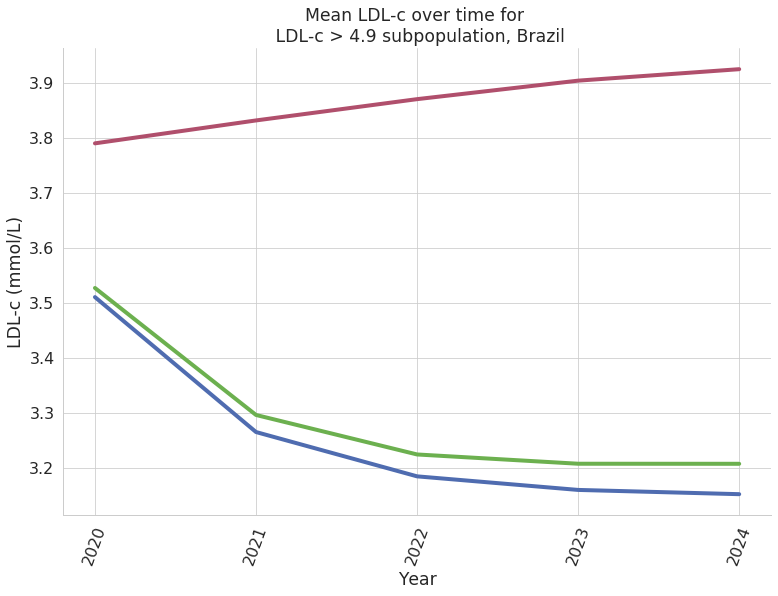

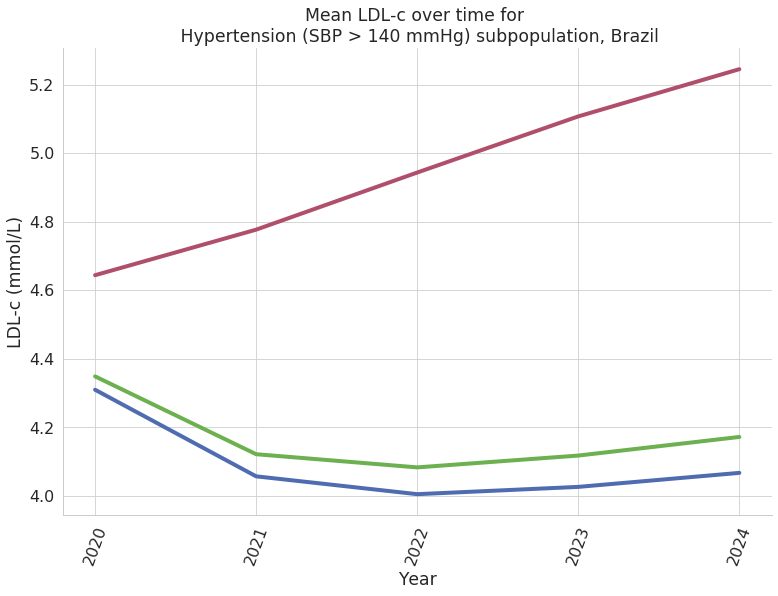

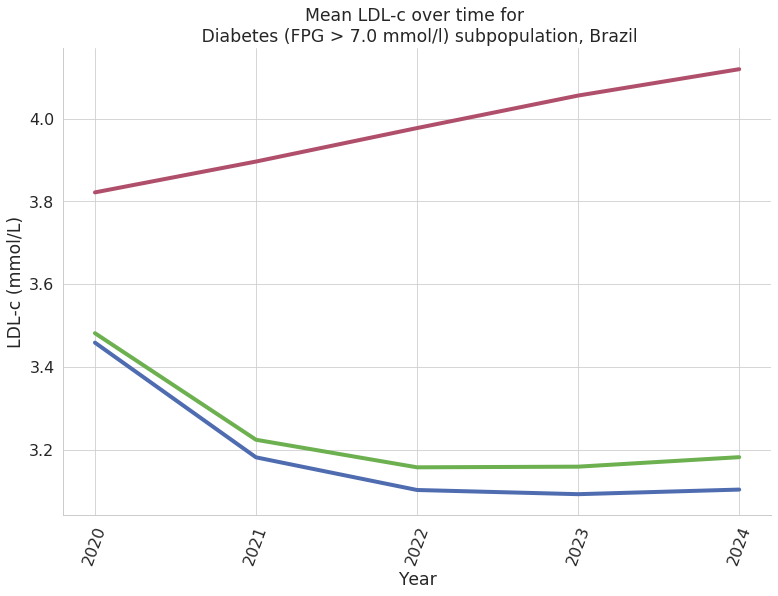

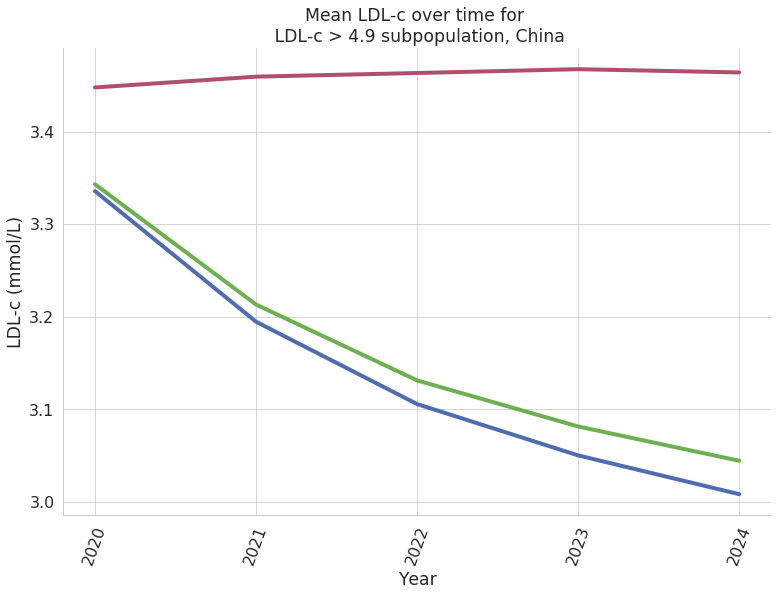

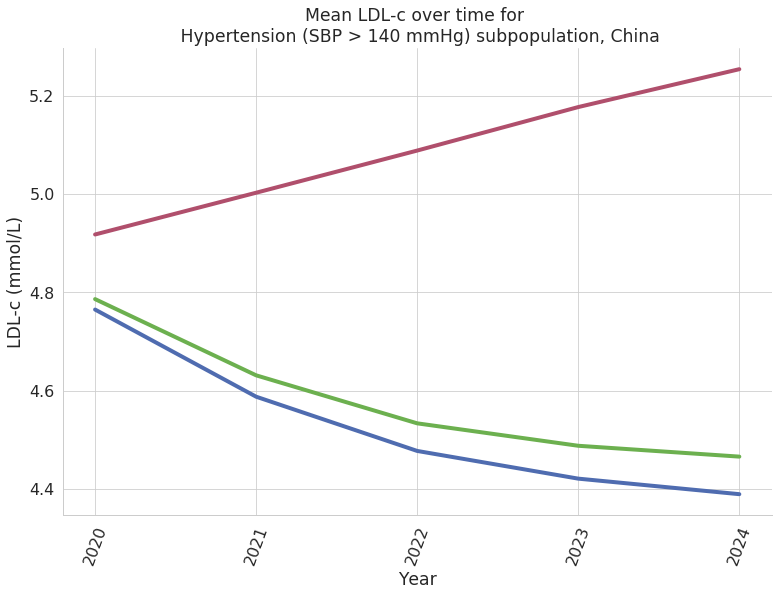

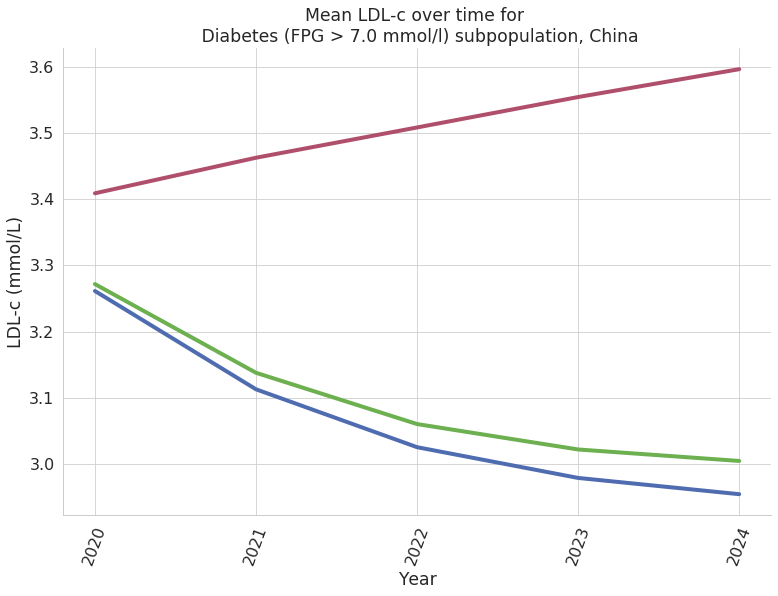

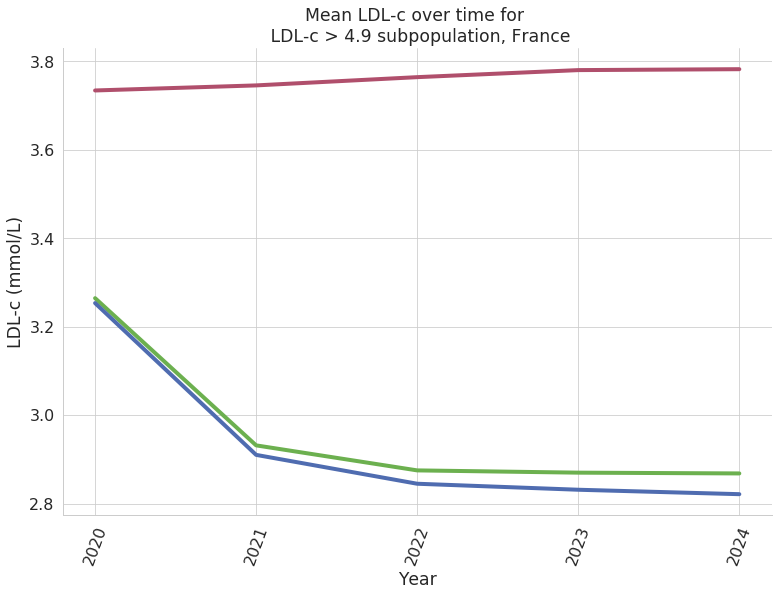

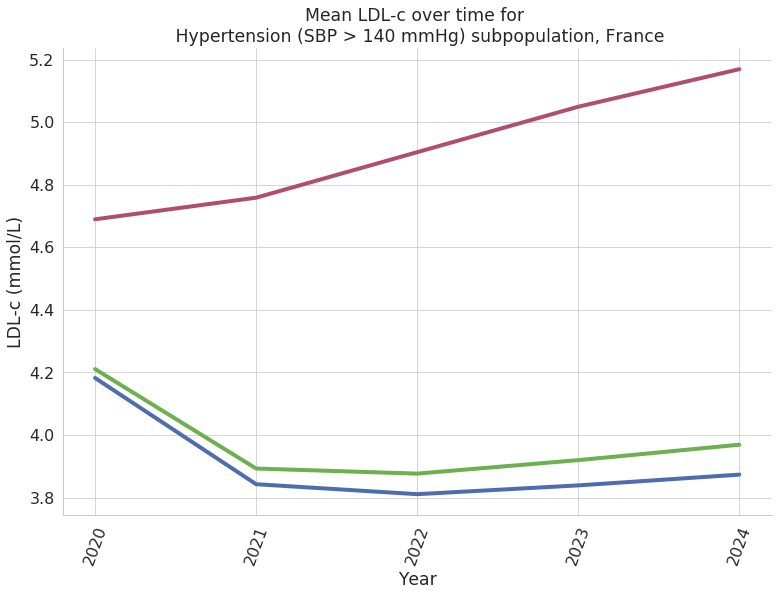

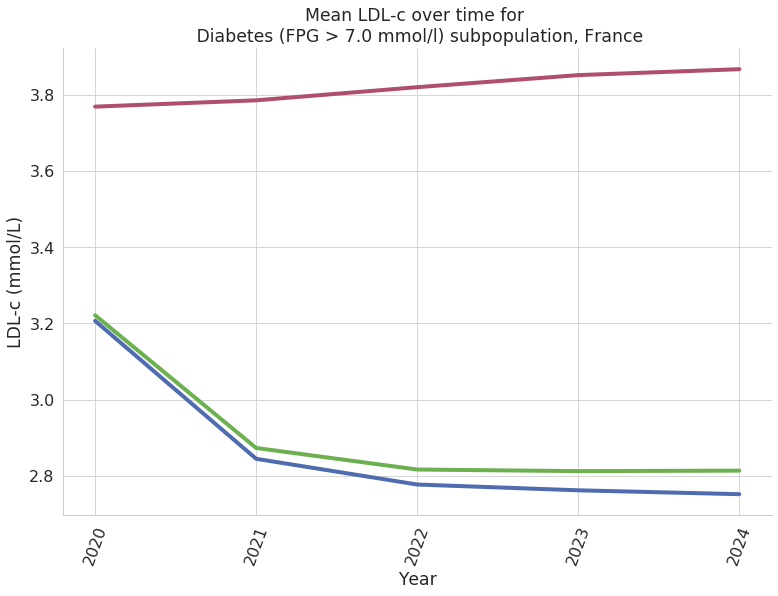

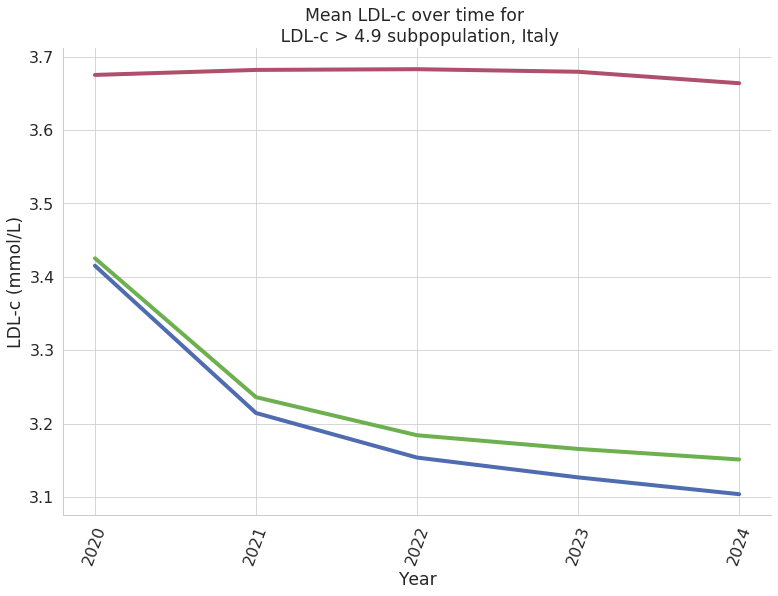

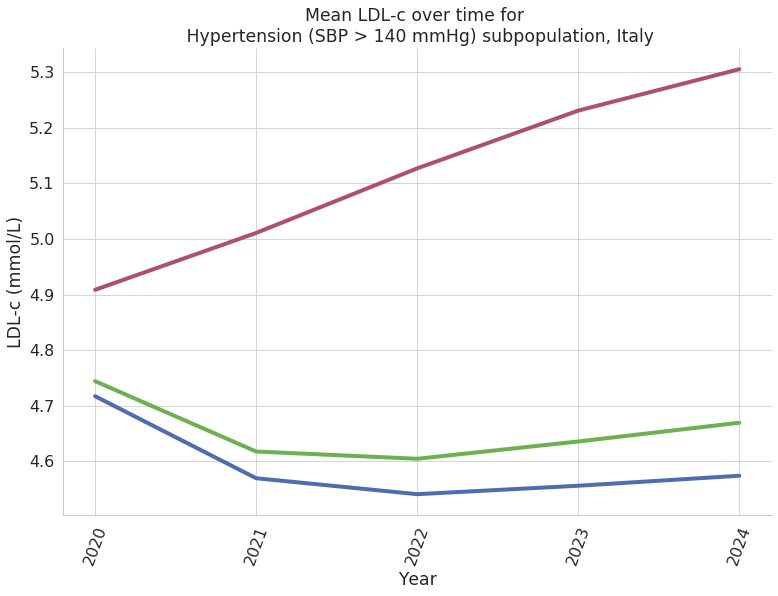

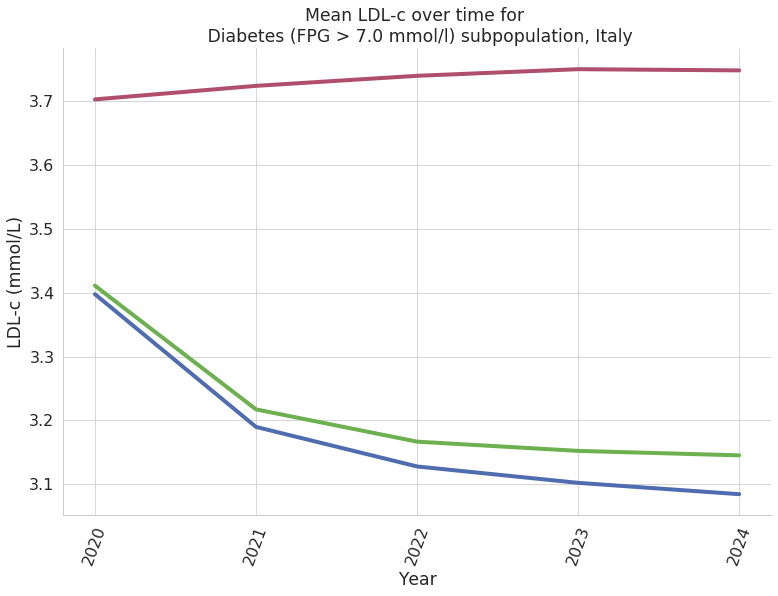

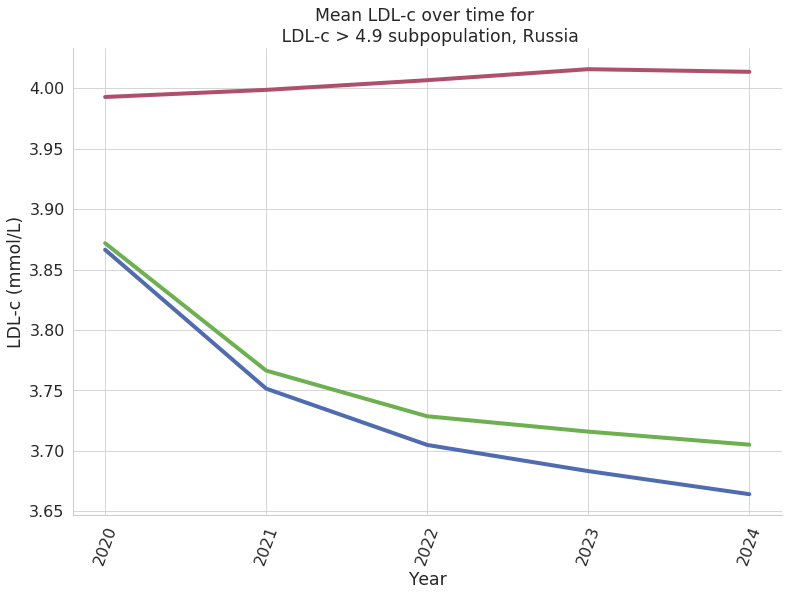

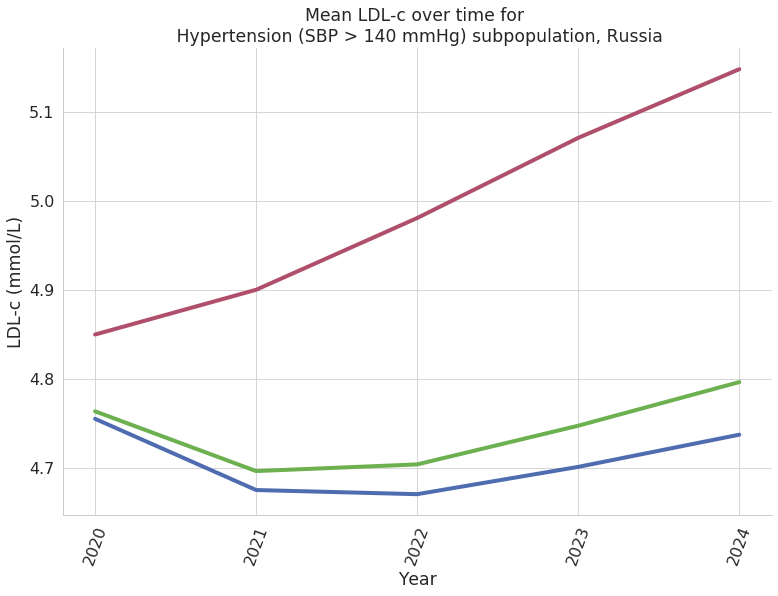

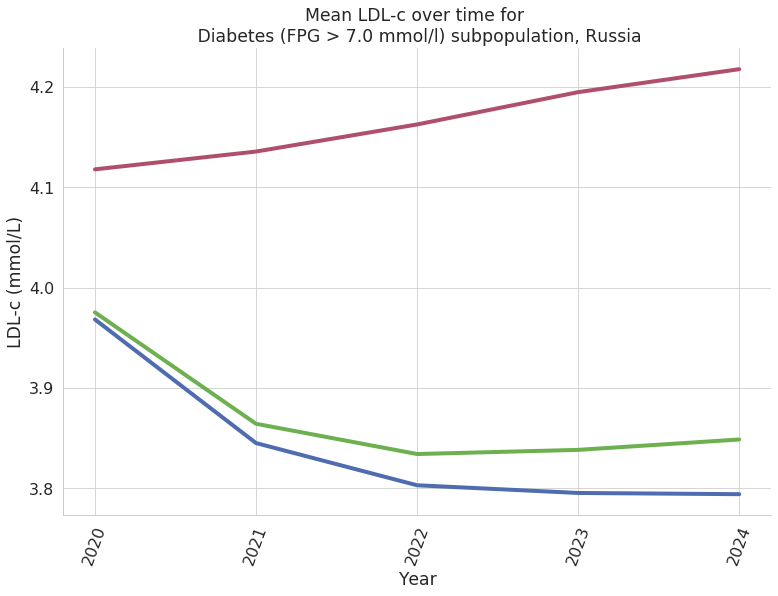

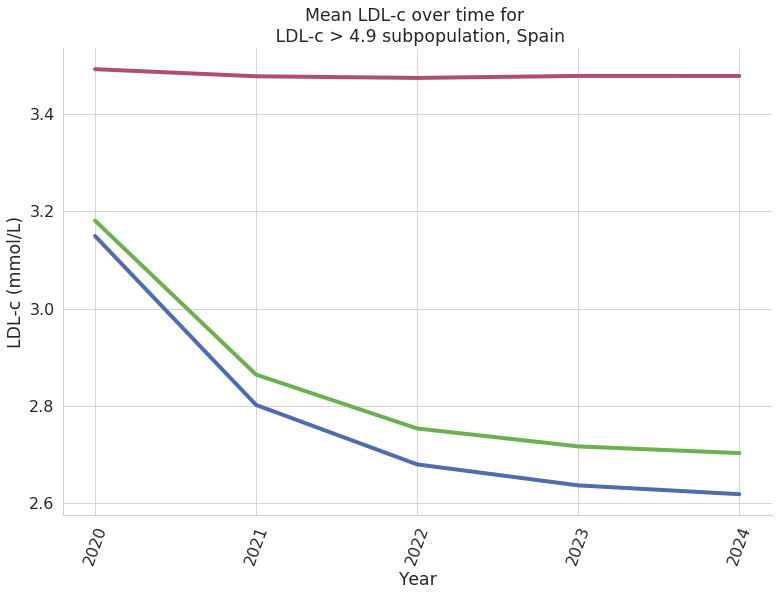

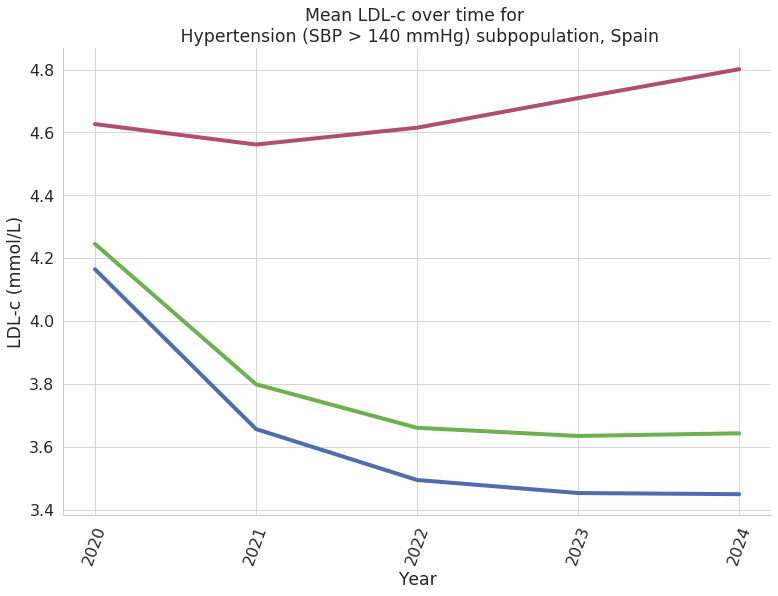

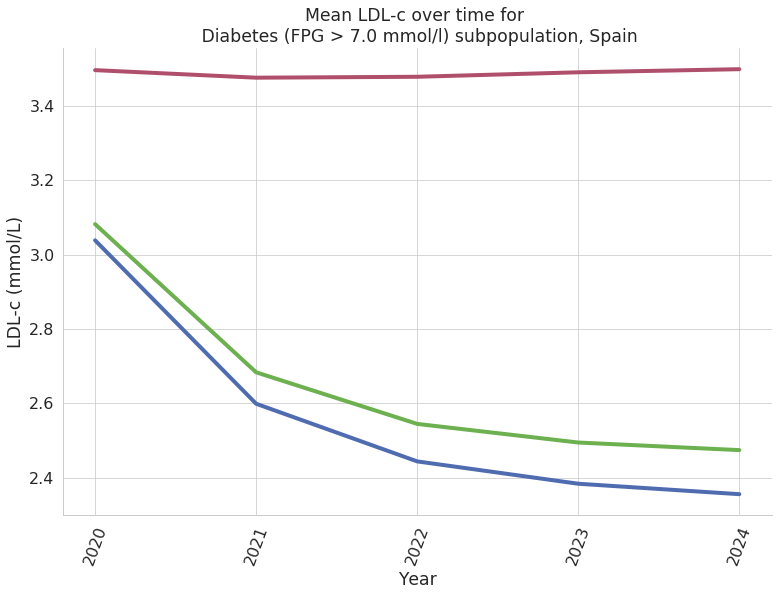

<Figure size 914.4x619.2 with 0 Axes>

In [147]:
def plot_ldl_c_mean_subpops(ldlc_subpops):
    ldlc_rf = ldlc_subpops
    df = ldlc_rf.groupby(['location', 'year', 'Scenario', 'subpopulation']).value.mean().reset_index()
    locations = ['Brazil', 'China', 'France', 'Italy','Russia', 'Spain']
#     locations = ['All locations']
    subpopulations = ['LDL-c > 4.9', 'Hypertension (SBP > 140 mmHg)', 'Diabetes (FPG > 7.0 mmol/l)']
    df['subpopulation'] = df.subpopulation.str.replace('high_ldl','LDL-c > 4.9')
    df['subpopulation'] = df.subpopulation.str.replace('hypertensive','Hypertension (SBP > 140 mmHg)')
    df['subpopulation'] = df.subpopulation.str.replace('diabetic','Diabetes (FPG > 7.0 mmol/l)')


    scenario_list = ['Business as Usual','Intervention 1 (multiple pills)', 'Intervention 2 (FDC)']
    palette_list = ['#B04F6C','#6CB04F','#4F6CB0']
    palette_dict = {x:v for x,v in zip(scenario_list,palette_list)}
    
    with PdfPages(str(save_path_j)+'/mean_ldl_c_over_time_model_outputs_subpopulations.pdf') as pdf:
        for location in locations: 
            for subpop in subpopulations:
#                 diff_upper = df.value.max()
#                 diff_upper = diff_upper * 1.1
#                 diff_lower = df.value.min()
#                 diff_lower = diff_lower * 0.85
                df_plot = df[(df.location == location) & (df.subpopulation == subpop)]


                g = sns.lineplot(x='year', y='value', hue = 'Scenario', palette= palette_dict, legend=False,
                                 linewidth=4, data=df_plot)

                g.set_title(f'Mean LDL-c over time for \n {subpop} subpopulation, {location}')
                plt.xticks(rotation=70)
                g.set_xlabel('Year')
                g.set_ylabel(f'LDL-c (mmol/L)')
#                 g.set_ylim(diff_lower,diff_upper)

                pdf.savefig(orientation = 'landscape', bbox_inches='tight')

                plt.show()
                plt.clf() 

plot_ldl_c_mean_subpops(ldlc_subpops)

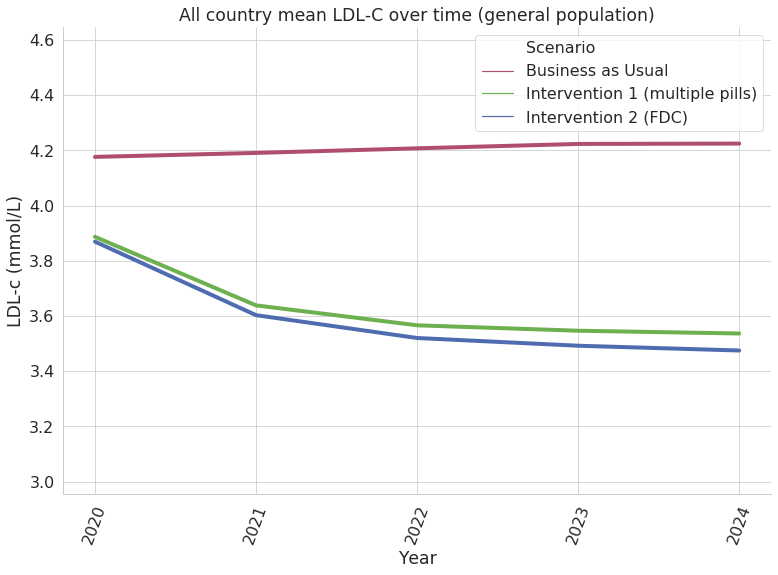

<Figure size 914.4x619.2 with 0 Axes>

In [118]:
def plot_ldl_c_mean(ldlc_rf_global):
    ldlc_rf = ldlc_rf_global
    df = ldlc_rf.groupby(['year', 'Scenario', 'subpopulation']).value.mean().reset_index()
    locations = ['Brazil', 'China', 'France', 'Italy','Russia', 'Spain']
#     locations = ['All locations']
#     subpopulations = ['diabetic', 'hypertensive']
    subpopulations = ['total_population']
#     df['subpopulation'] = df.subpopulation.str.replace('high_ldl','LDL-c > 4.9')
    scenario_list = ['Business as Usual','Intervention 1 (multiple pills)', 'Intervention 2 (FDC)']
    palette_list = ['#B04F6C','#6CB04F','#4F6CB0']
    palette_dict = {x:v for x,v in zip(scenario_list,palette_list)}
    
    with PdfPages(str(save_path_j)+'/mean_ldl_c_over_time_model_outputs_global.pdf') as pdf:
        diff_upper = df.value.max()
        diff_upper = diff_upper * 1.1
        diff_lower = df.value.min()
        diff_lower = diff_lower * 0.85

        for subpop in subpopulations:
            df_plot = df[(df.subpopulation == subpop)]


            g = sns.lineplot(x='year', y='value', hue = 'Scenario', palette= palette_dict,
                             linewidth=4, data=df_plot)

#                 g.set_title(f'Mean LDL-c level over time for {subpop} subpopulation, {location}')
            g.set_title(f'All country mean LDL-C over time (general population)')
            plt.xticks(rotation=70)
            g.set_xlabel('Year')
            g.set_ylabel(f'LDL-c (mmol/L)')
            g.set_ylim(diff_lower,diff_upper)

            pdf.savefig(orientation = 'landscape', bbox_inches='tight')

            plt.show()
            plt.clf() 

plot_ldl_c_mean(ldlc_rf_global)